# Table of contents

[Trial-wise cluster, joint-trial filter fit](#joint_filter)

[Trial-to-trial corr analysis](#t2t_analysis)

In [3]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import networkx as nx
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.1.1
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Neuropixels data. <a name='data'></a>

In [5]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [6]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

### Neurons Selection

In [7]:
probes = ['probeC', 'probeD', 'probeE'] # ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeD    78
Name: probe_description, dtype: int64

261

#### Fine Time Coupling Model

In [8]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
jittertool = jitter.JitterTool()

## Trials Selection

In [9]:
condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  246 temp freq [15.0] orient [0.0] contrast [0.8] [ 3798  3852  3947  3966  3979 31016 31026 31160 31186 49206 49245 49346 49372 49409 49412]
1  249 temp freq [8.0] orient [90.0] contrast [0.8] [ 3801  3810  3828  3911  3964 31002 31054 31055 31178 49257 49317 49341 49365 49395 49430]
2  256 temp freq [15.0] orient [270.0] contrast [0.8] [ 3811  3845  3942  3958 31003 31056 31112 31126 31137 31169 31191 49260 49305 49344 49381]
3  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
4  258 temp freq [4.0] orient [225.0] contrast [0.8] [ 3814  3895  3922  3967  3986  3997 31043 31151 31152 31175 31196 49251 49282 49340 49414]
5  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
6  261 temp freq [8.0] orient [135.0] contrast [0.8] [ 3817  3826  3875  3928 31020 31053 31129 31161 31162 49230 49254 49268 49275

## Spike Trains

In [10]:
trial_window = [0.4, 2.0]

spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


In [11]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(261, 285)

# Multivariate regression.

In [12]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 246), (1, 249), (2, 256), (3, 257), (4, 258), (5, 260), (6, 261), (7, 263), (8, 265), (9, 267), (10, 268), (11, 270), (12, 274), (13, 275), (14, 278), (15, 280), (16, 281), (17, 284), (18, 286)]


In [13]:
select_condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3798  3801  3810  3811  3813  3814  3816  3817  3819  3822  3824  3826  3828  3829  3831  3833  3835  3844
  3845  3848  3852  3855  3859  3860  3862  3866  3870  3872  3875  3876  3878  3880  3881  3882  3884  3886
  3888  3889  3895  3897  3898  3899  3900  3905  3906  3911  3912  3914  3917  3920  3921  3922  3924  3925
  3928  3930  3932  3933  3934  3936  3937  3938  3942  3943  3944  3946  3947  3948  3949  3951  3953  3955
  3956  3958  3959  3960  3962  3964  3966  3967  3968  3973  3979  3980  3981  3984  3986  3987  3988  3989
  3992  3995  3996  3997 31002 31003 31004 31014 31015 31016 31020 31021 31022 31024 31026 31027 31028 31033
 31034 31035 31039 31040 31043 31046 31047 31048 31051 31053 31054 31055 31056 31058 31062 31064 31066 31071
 31072 31075 31076 31078 31079 31080 31081 31085 31086 31089 31093 31096 31098 31104 31105 31112 31114 31116
 31125 31126 31129 31133 31135 31137 31142 31147 31148 31149 31151 31152 31154 31156 31159 31160 31161 31162
 31165 31166 31167 

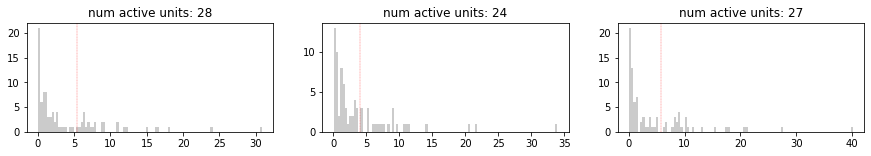

num_pairs: 672
num_pairs: 648


In [14]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

group_portion = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

### Load individual cluster, joint filter fit.
If we need the membership refit to match the original, the filter model should be one iteration behine.

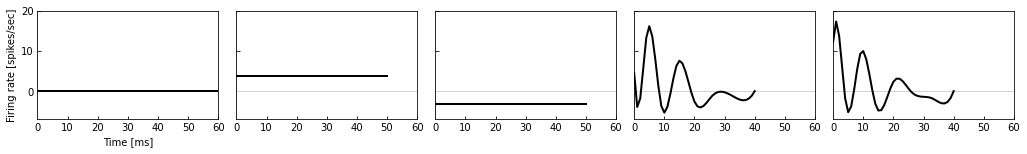

In [15]:
model_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/group_model_pars_joint_itr29_20211113_102001.pkl'
group_model_pars = util.load_variable(model_path)
file_path = project_dir + 'Output/fig/CD_DE_group_filters.pdf'
model.plot_multiple_filters(group_model_pars, ylim=[-7, 20], num_rows_cols=[1,5], file_path=None)

In [16]:
model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/'  # 0.20,0.20,0.20,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_uneven_11132021/'  # 0.15,0.25,0.20,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_uneven_11142021/'  # 0.25,0.15,0.25,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_uneven_11142021_1923/'  # 0.15,0.20,0.25,0.20,0.20

file_path = model_dir + 'filter_membership_CD_itr29_20211113_100406.pkl'
filter_membership_CD = util.load_variable(file_path)
file_path = model_dir + 'filter_membership_DE_itr29_20211113_100406.pkl'
filter_membership_DE = util.load_variable(file_path)

filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
_=model.filter_membership_statistics(filter_membership_CD, verbose=True)
_=model.filter_membership_statistics(filter_membership_DE, verbose=True)
_=model.filter_membership_statistics(filter_membership_joint, verbose=True)

filter_membership.shape (672, 285)
membership cnt [(0.0, 44863), (1.0, 39015), (2.0, 49584), (3.0, 28984), (4.0, 29074)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34628), (1.0, 36494), (2.0, 50835), (3.0, 30905), (4.0, 31818)]
filter_membership.shape (1320, 285)
membership cnt [(0.0, 79491), (1.0, 75509), (2.0, 100419), (3.0, 59889), (4.0, 60892)]


# Multivariate regression V1 --> LM --> AL

In [17]:
v1_neurons = active_units[active_units['probe_description']=='probeC'].index.values
lm_neurons = active_units[active_units['probe_description']=='probeD'].index.values
al_neurons = active_units[active_units['probe_description']=='probeE'].index.values

print('V1', len(v1_neurons), v1_neurons)
print('LM', len(lm_neurons), )
print('AL', len(al_neurons), al_neurons)

V1 28 [951102476 951102646 951102686 951102962 951102820 951103019 951103093 951103163 951103150 951103361
 951103290 951103262 951103238 951103332 951103380 951103498 951103488 951103530 951103632 951103624
 951103508 951103652 951103958 951103704 951103877 951104031 951103918 951104192]
LM 24
AL 27 [951112464 951112448 951112431 951112416 951112479 951112638 951112590 951112712 951112786 951112780
 951112768 951112845 951112906 951112937 951112992 951113075 951113056 951113039 951113191 951113175
 951113141 951113271 951113211 951113240 951113464 951113514 951113717]


In [18]:
output_dir = project_dir + f'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/'
filter_type = 2

import itertools
for n1, n2 in tqdm(itertools.product(v1_neurons, al_neurons), ncols=100, file=sys.stdout):
    neuron_pairs = [(n1, n2)]
    filter_membership_one = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)
    for trial_id in selected_trial_ids:
        filter_membership_one = model.update_filter_membership(spike_times, trial_window, group_portion,
                group_model_pars, filter_membership_one, [trial_id], verbose=False)
    df = filter_membership_one.T
    sub_trial_ids = df.index.values[(df==filter_type).values.reshape(-1)]
    lm_neurons = active_units[active_units['probe_description']=='probeD'].index.values
    spike_times_z = model.stack_spike_times_multivariate(spike_times, lm_neurons, sub_trial_ids)
    spike_times_x, spike_times_y = model.stack_spike_times_multivariate(spike_times, neuron_pairs[0], sub_trial_ids)

    #-------------- univariate -------------
    model_par_const = {'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
    model_par_square = {'filter_type': 'square', 'filter_length': 0.03,
                 'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.06,
                 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
    model_par_bspline = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 0.08, 'filter_length': 0.06, 'num_tail_drop': 1,
                 'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.06,
                 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
    model_par_multi = jittertool.multivariate_continuous_time_coupling_filter_regression(
        [[], spike_times_x], spike_times_y, trial_window, [model_par_const,model_par_square,])
    file_path = output_dir + f'univariate_filtertype{filter_type}_{neuron_pairs[0][0]}_{neuron_pairs[0][1]}.pkl'
    util.save_variable(file_path, model_par_multi)

    #-------------- multivariate -------------
    model_par_const = {'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.2, 'max_num_itrs': 500, 'epsilon': 1e-6}
    model_par_square0 = {'filter_type': 'square', 'filter_length': 0.02,
                 'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.06,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
    model_par_square = {'filter_type': 'square', 'filter_length': 0.03,
                 'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.06,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
    model_par_bspline0 = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 0.1, 'filter_length': 0.04, 'num_tail_drop': 1,
                 'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.05,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
    model_par_bspline = {'filter_type': 'bspline', 'num_knots': 6, 'knot_space_par': 0.1, 'filter_length': 0.04, 'num_tail_drop': 1,
                 'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.05,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
    spikes_list = [[], 
         spike_times_z[0], spike_times_z[1], spike_times_z[2], spike_times_z[3], 
         spike_times_z[4], spike_times_z[5], spike_times_z[6], spike_times_z[7], 
         spike_times_z[8], spike_times_z[9], spike_times_z[10], spike_times_z[11], 
         spike_times_z[12], spike_times_z[13], spike_times_z[14], spike_times_z[15], 
         spike_times_z[16], spike_times_z[17], spike_times_z[18], spike_times_z[19], 
         spike_times_z[20], spike_times_z[21], spike_times_z[22], spike_times_z[23], 
         spike_times_x]
    model_par_list = [model_par_const,
         model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(), 
         model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(), 
         model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(), 
         model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(), 
         model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(), 
         model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(), 
         model_par_square]
    model_par_multi = jittertool.multivariate_continuous_time_coupling_filter_regression(
        spikes_list, spike_times_y, trial_window, model_par_list)
    file_path = output_dir + f'multivariate_filtertype{filter_type}_{neuron_pairs[0][0]}_{neuron_pairs[0][1]}.pkl'
    util.save_variable(file_path, model_par_multi)


0it [00:00, ?it/s]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112464.pkl
1it [00:07,  7.91s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112448.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112448.pkl
2it [00:15,  7.95s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112431.pkl
3it [00:23,  7.76s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112416.pkl
4it [00:31,  7.85s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112590.pkl
7it [00:59,  8.76s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:2.410e-01
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112712.pkl
8it [01:15, 11.01s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112786.pkl
9it [01:22,  9.85s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112768.pkl
11it [01:42, 10.18s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112845.pkl
12it [01:49,  9.15s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112906.pkl
13it [01:57,  8.93s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951112937.pkl
14it [02:03,  8.14s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951113075.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951113075.pkl
16it [02:22,  8.63s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951113056.pkl
17it [02:29,  8.05s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951113039.pkl
18it [02:43,  9.84s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951113191.pkl
19it [02:50,  8.87s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951113514.pkl
26it [04:07, 10.55s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102476_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102476_951113717.pkl
27it [04:16, 10.12s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102646_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102646_951112479.pkl
32it [04:52,  7.62s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102646_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102646_951112638.pkl
33it [04:57,  6.89s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102646_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102646_951112768.pkl
38it [05:41,  8.72s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102646_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102646_951112845.pkl
39it [05:47,  7.71s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102646_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102646_951113191.pkl
46it [06:35,  6.89s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102646_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102646_951113175.pkl
47it [06:44,  7.41s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102646_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102646_951113514.pkl
53it [07:45,  9.38s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102646_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102646_951113717.pkl
54it [07:53,  8.96s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951112416.pkl
58it [08:42, 11.35s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951112479.pkl
59it [08:54, 11.60s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951112780.pkl
64it [10:01, 11.86s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:3.380e+12
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951112768.pkl
65it [10:20, 13.98s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951112845.pkl
66it [10:29, 12.39s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951113039.pkl
72it [11:47, 14.51s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951113191.pkl
73it [11:57, 13.30s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951113141.pkl
75it [12:21, 12.37s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951113271.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951113271.pkl
76it [12:54, 18.77s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951113514.pkl
80it [13:48, 14.62s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102686_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102686_951113717.pkl
81it [13:58, 13.36s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112479.pkl
86it [14:54, 11.56s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112638.pkl
87it [15:07, 12.01s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112590.pkl
88it [15:21, 12.46s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:2.520e-01
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112712.pkl
89it [15:40, 14.51s/it]

D:/Brain_Network/Code\jitter.py:3298: RuntimeWarning: invalid value encountered in add
  nll = -np.sum(np.log(lmbd_samples)) + lmbd_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112786.pkl
90it [15:50, 13.22s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112780.pkl
91it [15:57, 11.42s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112768.pkl
92it [16:15, 13.34s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112845.pkl
93it [16:24, 11.81s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112906.pkl
94it [16:33, 11.21s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951112937.pkl
95it [16:43, 10.79s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_9511

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951113240.pkl
105it [19:00, 13.38s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951113464.pkl
106it [19:16, 14.17s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951113514.pkl
107it [19:29, 13.87s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102962_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102962_951113717.pkl
108it [19:40, 12.95s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102820_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102820_951112464.pkl
109it [19:49, 11.66s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102820_951112448.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102820_951112448.pkl
110it [19:58, 10.80s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102820_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102820_951112431.pkl
111it [20:06, 10.13s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102820_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102820_951112416.pkl
112it [20:14,  9.53s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102820_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102820_951112479.pkl
113it [20:23,  9.14s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102820_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102820_951113191.pkl
127it [22:30,  8.50s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102820_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102820_951113175.pkl
128it [22:38,  8.52s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:3298: RuntimeWarning: invalid value encountered in add
  nll = -np.sum(np.log(lmbd_samples)) + lmbd_integral


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102820_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102820_951113240.pkl
132it [23:19,  9.35s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951102820_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951102820_951113464.pkl
133it [23:32, 10.28s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951112431.pkl
138it [24:14,  8.46s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951112416.pkl
139it [24:22,  8.31s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951112590.pkl
142it [24:45,  7.81s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951112712.pkl
143it [24:58,  9.22s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951112786.pkl
144it [25:05,  8.55s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951112780.pkl
145it [25:12,  8.11s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951112845.pkl
147it [25:27,  7.78s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951112906.pkl
148it [25:35,  7.61s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951112992.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951112992.pkl
150it [25:50,  7.78s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951113075.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951113075.pkl
151it [25:56,  7.35s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951113056.pkl
152it [26:02,  6.92s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:4.882e-01
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951113039.pkl
153it [26:11,  7.41s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:3.039e-03
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951113191.pkl
154it [26:17,  7.02s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951113175.pkl
155it [26:25,  7.16s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103019_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103019_951113141.pkl
156it [26:32,  7.16s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112448.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112448.pkl
164it [27:54, 10.20s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112431.pkl
165it [28:04, 10.33s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112416.pkl
166it [28:15, 10.38s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112479.pkl
167it [28:27, 10.82s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112638.pkl
168it [28:41, 11.72s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112590.pkl
169it [28:54, 12.15s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:4.176e-01
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112712.pkl
170it [29:16, 15.25s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112786.pkl
171it [29:27, 13.83s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112906.pkl
175it [30:16, 12.34s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951112937.pkl
176it [30:26, 11.79s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951113075.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951113075.pkl
178it [30:51, 11.97s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951113056.pkl
179it [31:00, 11.04s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951113175.pkl
182it [31:37, 11.58s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951113141.pkl
183it [31:47, 11.20s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951113271.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951113271.pkl
184it [32:17, 16.64s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951113514.pkl
188it [33:05, 13.02s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:2.408e-04
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103093_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103093_951113717.pkl
189it [33:15, 12.18s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112464.pkl
190it [33:25, 11.68s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112448.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112448.pkl
191it [33:37, 11.72s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112431.pkl
192it [33:48, 11.56s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112416.pkl
193it [33:59, 11.18s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112479.pkl
194it [34:10, 11.20s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112786.pkl
198it [35:07, 13.43s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112780.pkl
199it [35:14, 11.53s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:8.760e+10
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112768.pkl
200it [35:31, 13.26s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112845.pkl
201it [35:40, 11.95s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951112906.pkl
202it [35:49, 11.15s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951113056.pkl
206it [36:31, 10.42s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103163_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103163_951113039.pkl
207it [36:48, 12.31s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951112448.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951112448.pkl
218it [39:18, 11.76s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951112431.pkl
219it [39:31, 11.88s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951112416.pkl
220it [39:41, 11.58s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951112479.pkl
221it [39:56, 12.39s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951112780.pkl
226it [41:09, 13.08s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951112768.pkl
227it [41:29, 15.04s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951112845.pkl
228it [41:39, 13.63s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951112906.pkl
229it [41:51, 13.31s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951112937.pkl
230it [42:02, 12.55s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951113141.pkl
237it [43:36, 12.70s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951113271.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951113271.pkl
238it [44:07, 18.35s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951113211.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951113211.pkl
239it [44:21, 16.96s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103150_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103150_951113240.pkl
240it [44:31, 14.99s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:1.527e-01
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103361_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103361_951112712.pkl
251it [47:17, 16.77s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103361_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103361_951112786.pkl
252it [47:27, 14.81s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103361_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103361_951112780.pkl
253it [47:34, 12.36s/it]

D:/Brain_Network/Code\jitter.py:8302: RuntimeWarning: overflow encountered in square
  hessian = X[non_zero_ind].T @ (X[non_zero_ind] / np.square(lmbd[non_zero_ind]))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103361_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103361_951112768.pkl
254it [47:51, 13.75s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103361_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103361_951112845.pkl
255it [48:00, 12.23s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103361_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103361_951112906.pkl
256it [48:09, 11.49s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103361_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103361_951112937.pkl
257it [48:20, 11.20s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103361_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103361_951113240.pkl
267it [50:42, 13.99s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103361_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103361_951113464.pkl
268it [50:58, 14.72s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951112638.pkl
276it [52:19, 10.39s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951112590.pkl
277it [52:29, 10.27s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951112780.pkl
280it [53:02,  9.86s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:2.003e-01
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951112768.pkl
281it [53:15, 11.04s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951112845.pkl
282it [53:23,  9.87s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951112906.pkl
283it [53:31,  9.58s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951113075.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951113075.pkl
286it [54:02,  9.78s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951113056.pkl
287it [54:09,  8.95s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951113039.pkl
288it [54:22, 10.26s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951113141.pkl
291it [54:49,  9.60s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951113271.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951113271.pkl
292it [55:10, 13.09s/it]

D:/Brain_Network/Code\jitter.py:4075: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951113211.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951113211.pkl
293it [55:19, 11.74s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951113240.pkl
294it [55:27, 10.61s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103290_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103290_951113464.pkl
295it [55:40, 11.31s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951112416.pkl
301it [56:49, 11.78s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951112479.pkl
302it [57:01, 12.04s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:2.245e-01
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951112712.pkl
305it [57:50, 15.28s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951112786.pkl
306it [58:01, 13.88s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951112780.pkl
307it [58:08, 11.96s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951112768.pkl
308it [58:25, 13.36s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951112906.pkl
310it [58:45, 11.77s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951112937.pkl
311it [58:56, 11.48s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_95

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951113075.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951113075.pkl
313it [59:23, 12.30s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951113056.pkl
314it [59:32, 11.39s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:2.370e-06
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951113039.pkl
315it [59:50, 13.18s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951113191.pkl
316it [1:00:00, 12.42s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951113141.pkl
318it [1:00:26, 12.51s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103262_951113271.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103262_951113271.pkl
319it [1:00:54, 17.27s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951112786.pkl
333it [1:03:53, 13.85s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951112780.pkl
334it [1:04:01, 12.06s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951112845.pkl
336it [1:04:27, 12.11s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951112906.pkl
337it [1:04:37, 11.48s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951112937.pkl
338it [1:04:49, 11.48s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951113056.pkl
341it [1:05:24, 11.00s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951113039.pkl
342it [1:05:41, 12.71s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951113191.pkl
343it [1:05:51, 11.90s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951113175.pkl
344it [1:06:02, 11.86s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951113514.pkl
350it [1:07:29, 13.49s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103238_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103238_951113717.pkl
351it [1:07:40, 12.56s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112464.pkl
352it [1:07:51, 12.33s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112448.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112448.pkl
353it [1:08:03, 12.17s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112431.pkl
354it [1:08:13, 11.56s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112416.pkl
355it [1:08:24, 11.33s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112479.pkl
356it [1:08:34, 10.96s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112638.pkl
357it [1:08:46, 11.18s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112590.pkl
358it [1:08:59, 11.87s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112712.pkl
359it [1:09:17, 13.63s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112786.pkl
360it [1:09:26, 12.26s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112780.pkl
361it [1:09:32, 10.36s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:6.325e+14
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112768.pkl
362it [1:09:46, 11.47s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112845.pkl
363it [1:09:54, 10.51s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:1.831e-04
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112906.pkl
364it [1:10:03, 10.06s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112937.pkl
365it [1:10:13,  9.90s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951112992.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951112992.pkl
366it [1:10:28, 11.42s/it]

D:/Brain_Network/Code\jitter.py:3298: RuntimeWarning: invalid value encountered in add
  nll = -np.sum(np.log(lmbd_samples)) + lmbd_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951113075.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951113075.pkl
367it [1:10:37, 10.85s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951113056.pkl
368it [1:10:46, 10.11s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951113039.pkl
369it [1:11:01, 11.51s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951113191.pkl
370it [1:11:10, 10.86s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951113175.pkl
371it [1:11:20, 10.74s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951113240.pkl
375it [1:12:17, 12.71s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951113464.pkl
376it [1:12:32, 13.36s/it]

D:/Brain_Network/Code\jitter.py:4075: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951113514.pkl
377it [1:12:42, 12.14s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103332_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103332_951113717.pkl
378it [1:12:50, 11.06s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112464.pkl
379it [1:13:00, 10.82s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112431.pkl
381it [1:13:23, 11.00s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112416.pkl
382it [1:13:33, 10.64s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112590.pkl
385it [1:14:07, 11.08s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112712.pkl
386it [1:14:27, 13.96s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112780.pkl
388it [1:14:45, 11.27s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112768.pkl
389it [1:15:04, 13.55s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112845.pkl
390it [1:15:12, 11.94s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112906.pkl
391it [1:15:22, 11.36s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112937.pkl
392it [1:15:32, 10.86s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951112992.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951112992.pkl
393it [1:15:48, 12.35s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951113056.pkl
395it [1:16:07, 10.94s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951113039.pkl
396it [1:16:25, 13.26s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951113514.pkl
404it [1:18:06, 12.01s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103380_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103380_951113717.pkl
405it [1:18:15, 11.32s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103498_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103498_951112464.pkl
406it [1:18:26, 11.09s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103498_951112448.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103498_951112448.pkl
407it [1:18:38, 11.33s/it]

D:/Brain_Network/Code\jitter.py:4075: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103498_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103498_951112431.pkl
408it [1:18:48, 11.05s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103498_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103498_951112416.pkl
409it [1:18:58, 10.71s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103498_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103498_951112937.pkl
419it [1:21:01, 11.02s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103498_951112992.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103498_951112992.pkl
420it [1:21:18, 12.64s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103498_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103498_951113039.pkl
423it [1:21:55, 13.06s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103498_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103498_951113191.pkl
424it [1:22:05, 12.12s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112431.pkl
435it [1:24:31, 10.85s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112416.pkl
436it [1:24:41, 10.76s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112479.pkl
437it [1:24:52, 10.83s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112590.pkl
439it [1:25:16, 11.19s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112712.pkl
440it [1:25:32, 12.79s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112786.pkl
441it [1:25:41, 11.45s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112780.pkl
442it [1:25:47,  9.80s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112768.pkl
443it [1:26:02, 11.40s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112845.pkl
444it [1:26:09, 10.27s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951112906.pkl
445it [1:26:19, 10.01s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951113075.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951113075.pkl
448it [1:26:51, 10.45s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951113056.pkl
449it [1:27:00, 10.14s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951113039.pkl
450it [1:27:18, 12.37s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951113191.pkl
451it [1:27:27, 11.38s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951113175.pkl
452it [1:27:38, 11.38s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951113240.pkl
456it [1:28:36, 12.83s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951113464.pkl
457it [1:28:49, 12.95s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951113514.pkl
458it [1:28:59, 11.91s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103488_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103488_951113717.pkl
459it [1:29:08, 11.19s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951112431.pkl
462it [1:29:43, 11.42s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951112416.pkl
463it [1:29:53, 11.05s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951112479.pkl
464it [1:30:05, 11.37s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951112638.pkl
465it [1:30:20, 12.53s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:1.100e-03
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951112768.pkl
470it [1:31:31, 14.23s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951112845.pkl
471it [1:31:40, 12.62s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951112937.pkl
473it [1:31:59, 11.09s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951112992.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951112992.pkl
474it [1:32:15, 12.52s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951113075.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951113075.pkl
475it [1:32:25, 11.84s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951113056.pkl
476it [1:32:35, 11.08s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951113211.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951113211.pkl
482it [1:34:08, 15.74s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:4075: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
D:/Brain_Network/Code\jitter.py:3298: RuntimeWarning: invalid value encountered in add
  nll = -np.sum(np.log(lmbd_samples)) + lmbd_integral


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951113240.pkl
483it [1:34:16, 13.63s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103530_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103530_951113464.pkl
484it [1:34:31, 13.84s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4075: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112431.pkl
489it [1:35:17,  9.83s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112416.pkl
490it [1:35:25,  9.36s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112479.pkl
491it [1:35:35,  9.32s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112638.pkl
492it [1:35:45,  9.49s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 100. Last err:1.176e+01
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112590.pkl
493it [1:35:55,  9.84s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:3.985e-01
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112712.pkl
494it [1:36:10, 11.20s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112786.pkl
495it [1:36:19, 10.64s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112780.pkl
496it [1:36:24,  8.98s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:3.160e+13
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112768.pkl
497it [1:36:36,  9.92s/it]

D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112845.pkl
498it [1:36:43,  8.94s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951112906.pkl
499it [1:36:50,  8.53s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951113075.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951113075.pkl
502it [1:37:19,  9.13s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951113056.pkl
503it [1:37:26,  8.65s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951113039.pkl
504it [1:37:40, 10.14s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951113175.pkl
506it [1:37:56,  9.28s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951113141.pkl
507it [1:38:06,  9.26s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951113211.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951113211.pkl
509it [1:38:34, 11.31s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951113240.pkl
510it [1:38:41, 10.30s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951113514.pkl
512it [1:39:03, 10.36s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103632_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103632_951113717.pkl
513it [1:39:11,  9.74s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103624_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103624_951112416.pkl
517it [1:39:53, 10.32s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103624_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103624_951112479.pkl
518it [1:40:03, 10.39s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103624_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103624_951112590.pkl
520it [1:40:26, 10.79s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103624_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103624_951112712.pkl
521it [1:40:45, 13.09s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103624_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103624_951112780.pkl
523it [1:41:02, 10.66s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103624_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103624_951112768.pkl
524it [1:41:20, 12.81s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103624_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103624_951113717.pkl
540it [1:44:28, 11.58s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951112464.pkl
541it [1:44:38, 10.91s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951112780.pkl
550it [1:46:20, 11.13s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951112768.pkl
551it [1:46:36, 12.53s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951112845.pkl
552it [1:46:44, 11.23s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951112906.pkl
553it [1:46:53, 10.40s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951112937.pkl
554it [1:47:02, 10.07s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951113056.pkl
557it [1:47:35, 10.32s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951113039.pkl
558it [1:47:55, 13.15s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951113211.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951113211.pkl
563it [1:49:13, 16.05s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103508_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103508_951113240.pkl
564it [1:49:22, 13.88s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112431.pkl
570it [1:50:35, 12.02s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112416.pkl
571it [1:50:45, 11.44s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112479.pkl
572it [1:50:56, 11.30s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112638.pkl
573it [1:51:10, 12.12s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112590.pkl
574it [1:51:21, 11.85s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112712.pkl
575it [1:51:43, 14.94s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112780.pkl
577it [1:52:00, 11.52s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112768.pkl
578it [1:52:17, 13.11s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112845.pkl
579it [1:52:25, 11.75s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951112906.pkl
580it [1:52:35, 11.08s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951113039.pkl
585it [1:53:38, 12.93s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951113191.pkl
586it [1:53:49, 12.33s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951113211.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951113211.pkl
590it [1:54:52, 15.42s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103652_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103652_951113240.pkl
591it [1:55:01, 13.52s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112448.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112448.pkl
596it [1:55:58, 11.53s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112431.pkl
597it [1:56:10, 11.50s/it]

D:/Brain_Network/Code\jitter.py:3298: RuntimeWarning: invalid value encountered in add
  nll = -np.sum(np.log(lmbd_samples)) + lmbd_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112416.pkl
598it [1:56:20, 11.15s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112479.pkl
599it [1:56:30, 10.90s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112590.pkl
601it [1:56:55, 11.85s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112712.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112712.pkl
602it [1:57:13, 13.71s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112780.pkl
604it [1:57:30, 10.79s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112768.pkl
605it [1:57:43, 11.66s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112845.pkl
606it [1:57:52, 10.87s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951112906.pkl
607it [1:58:02, 10.60s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:1.794e-04
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')
D:/Brain_Network/Code\jitter.py:4075: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951113191.pkl
613it [1:59:09, 11.09s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951113175.pkl
614it [1:59:19, 10.91s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951113141.pkl
615it [1:59:30, 10.87s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951113271.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951113271.pkl
616it [1:59:54, 14.73s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951113240.pkl
618it [2:00:14, 12.40s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951113464.pkl
619it [2:00:29, 12.97s/it]

D:/Brain_Network/Code\jitter.py:4075: RuntimeWarning: invalid value encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951113514.pkl
620it [2:00:38, 11.74s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103958_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103958_951113717.pkl
621it [2:00:46, 10.81s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103704_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103704_951112464.pkl
622it [2:00:56, 10.61s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103704_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103704_951112780.pkl
631it [2:02:52, 12.12s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:9.490e+09
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103704_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103704_951112768.pkl
632it [2:03:11, 14.29s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103704_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103704_951112845.pkl
633it [2:03:20, 12.67s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4075: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103704_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103704_951112937.pkl
635it [2:03:40, 11.45s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103704_951112992.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103704_951112992.pkl
636it [2:03:57, 13.03s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103704_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103704_951113514.pkl
647it [2:06:34, 14.60s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103704_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103704_951113717.pkl
648it [2:06:45, 13.49s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112464.pkl
649it [2:06:55, 12.51s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112448.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112448.pkl
650it [2:07:07, 12.22s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112431.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112431.pkl
651it [2:07:18, 12.02s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112416.pkl
652it [2:07:28, 11.49s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112479.pkl
653it [2:07:39, 11.21s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112638.pkl
654it [2:07:51, 11.48s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112780.pkl
658it [2:08:37, 10.64s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112768.pkl
659it [2:08:53, 12.34s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112906.pkl
661it [2:09:11, 10.60s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:3.877e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112937.pkl
662it [2:09:22, 10.69s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951112992.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951112992.pkl
663it [2:09:35, 11.51s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951113141.pkl
669it [2:10:36, 10.18s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951113271.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951113271.pkl
670it [2:11:01, 14.53s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951113240.pkl
672it [2:11:21, 12.24s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951113464.pkl
673it [2:11:35, 12.67s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951113514.pkl
674it [2:11:44, 11.71s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103877_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103877_951113717.pkl
675it [2:11:54, 10.98s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112464.pkl
676it [2:12:04, 10.92s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112416.pkl
679it [2:12:37, 10.94s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112479.pkl
680it [2:12:49, 11.09s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112638.pkl
681it [2:13:01, 11.39s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112590.pkl
682it [2:13:13, 11.45s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112786.pkl
684it [2:13:44, 13.14s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112780.pkl
685it [2:13:51, 11.15s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:4.341e-03
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112768.pkl
686it [2:14:06, 12.57s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112845.pkl
687it [2:14:15, 11.45s/it]

D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112906.pkl
688it [2:14:25, 10.88s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951112937.pkl
689it [2:14:35, 10.63s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951113056.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951113056.pkl
692it [2:15:07, 10.17s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951113039.pkl
693it [2:15:22, 11.75s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951113191.pkl
694it [2:15:32, 11.14s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951113141.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951113141.pkl
696it [2:15:51, 10.44s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951113271.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951113271.pkl
697it [2:16:15, 14.55s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104031_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104031_951113717.pkl
702it [2:17:08, 10.95s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951112464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951112464.pkl
703it [2:17:17, 10.41s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951112416.pkl
706it [2:17:43,  9.28s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951112479.pkl
707it [2:17:53,  9.33s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951112638.pkl
708it [2:18:03,  9.53s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951112780.pkl
712it [2:18:44,  9.28s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951112768.pkl
713it [2:18:56, 10.14s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951113039.pkl
720it [2:20:03, 10.77s/it]

D:/Brain_Network/Code\jitter.py:8323: UserWarning: Reach max itrs 500. Last err:1.242e-06
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951113191.pkl
721it [2:20:11,  9.98s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951113175.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951113175.pkl
722it [2:20:20,  9.79s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951113211.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951113211.pkl
725it [2:21:03, 12.48s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951113240.pkl
726it [2:21:11, 11.21s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951113464.pkl
727it [2:21:24, 11.68s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951113514.pkl
728it [2:21:33, 10.74s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951103918_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951103918_951113717.pkl
729it [2:21:41,  9.98s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112416.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112416.pkl
733it [2:22:27, 11.12s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112479.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112479.pkl
734it [2:22:38, 10.97s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112638.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112638.pkl
735it [2:22:51, 11.47s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112590.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112590.pkl
736it [2:23:05, 12.26s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112786.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112786.pkl
738it [2:23:36, 13.52s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112780.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112780.pkl
739it [2:23:43, 11.46s/it]

D:/Brain_Network/Code\jitter.py:8302: RuntimeWarning: overflow encountered in square
  hessian = X[non_zero_ind].T @ (X[non_zero_ind] / np.square(lmbd[non_zero_ind]))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112768.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112768.pkl
740it [2:24:00, 13.21s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112845.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112845.pkl
741it [2:24:09, 11.81s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112906.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112906.pkl
742it [2:24:19, 11.33s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112937.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112937.pkl
743it [2:24:30, 11.19s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951112992.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951112992.pkl
744it [2:24:47, 13.14s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951113039.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951113039.pkl
747it [2:25:28, 14.15s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951113191.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951113191.pkl
748it [2:25:37, 12.61s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951113240.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951113240.pkl
753it [2:26:52, 14.02s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951113464.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951113464.pkl
754it [2:27:08, 14.63s/it]

D:/Brain_Network/Code\jitter.py:4063: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4065: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4090: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))


util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951113514.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951113514.pkl
755it [2:27:20, 13.77s/it]util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/univariate_filtertype2_951104192_951113717.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021_multi_reg/multivariate_filtertype2_951104192_951113717.pkl
756it [2:27:30, 11.71s/it]


In [ ]:
multivariate_951102476_951112590
multivariate_951102476_951113240
multivariate_951102646_951112431
multivariate_951102646_951112786
multivariate_951102820_951112786
multivariate_951102820_951113039
multivariate_951103019_951112448




## Select neurons + trials of interest.

##### selections are based on correlated filters.

In [474]:
contingency_mat, chi2t_df, pval_df = model.calculate_filter_memberships_corr(filter_membership_CD, filter_membership_DE)

100%|█████████████████████████████████████████████████████████████| 672/672 [01:46<00:00,  6.31it/s]


951108540 433
951108557 44
951108867 644
951109006 592
951109118 599
951109307 398
951109338 557
951109329 281
951109435 474
951109594 755
951109702 672
951102476 951112780 156
951102646 951112638 177
951102646 951112780 451
951102646 951112937 113
951102646 951113056 63
951102646 951113039 265
951102820 951112780 249
951103019 951112780 424
Total:7989	hub:5449	bro-rec:1898	sum:7347	intersect:7240
len(diag_pairs), len(bro_rec_pairs) 11 8
Total sample size 435456
p-val		cnt	portion
p-val<1e-06:	5441	1.25e-02
p-val<1e-07:	4484	1.03e-02
p-val<1e-08:	3794	8.71e-03
p-val<1e-10:	2690	6.18e-03
FDR BY
alpha<0.05:	7989
alpha<0.01:	6733
FWER Bonferroni
alpha<0.05:	4549
alpha<0.01:	4037
Row-col level-0 match!


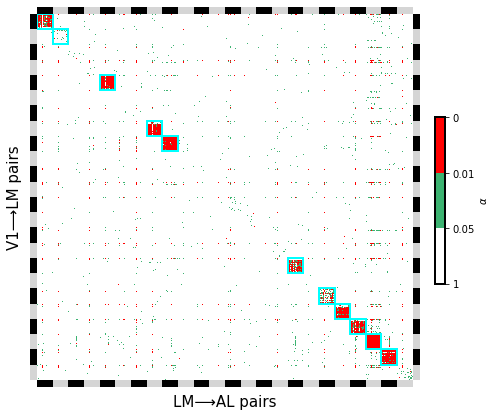

In [476]:
diag_neurons, bro_rec_neurons, diag_pairs, bro_rec_pairs = model.significant_pair_block_pattern_analysis(
    pval_df, contingency_mat, multitest_method='fdr_by')
model.plot_filter_memberships_corr_beautiful(
    contingency_mat, chi2t_df, pval_df, level_order='10', multitest_method='fdr_by', file_path=None)

In [451]:
active_units[active_units['probe_description'] == 'probeD'].index.values

array([951108540, 951108557, 951108685, 951108721, 951108867, 951110003, 951108877, 951108911, 951109006,
       951109184, 951109137, 951109213, 951109118, 951109191, 951109262, 951109299, 951109282, 951109307,
       951109338, 951109329, 951109319, 951109435, 951109594, 951109702], dtype=int64)

##### Select single pair.

In [343]:
(neuron_1, neuron_2), (neuron_3, neuron_4), trial_ids = model.select_neurons_trials_from_significant_pairs(diag_pairs, filter_membership_joint)
spike_times_1 = spike_times.loc[neuron_1, trial_ids].tolist()
spike_times_2 = spike_times.loc[neuron_2, trial_ids].tolist()
spike_times_3 = spike_times.loc[neuron_3, trial_ids].tolist()
spike_times_4 = spike_times.loc[neuron_4, trial_ids].tolist()

generator = hierarchical_model_generator.HierarchicalModelGenerator()
generator.spike_times_statistics(spike_times_1, 2, verbose=0)
generator.spike_times_statistics(spike_times_2, 2, verbose=0)
generator.spike_times_statistics(spike_times_4, 2, verbose=0)

(951103652, 951109329) (951109329, 951113271)
[[18.  6.  3.  6.  7.]
 [ 2. 36.  4. 14. 20.]
 [ 2. 23. 14. 20. 18.]
 [ 3. 13.  3. 15. 15.]
 [ 2. 24.  2.  7.  8.]]
num trials: 36
layers 2, nodes 1, trials 36
meanFR 8.042	meanISI 10.37
layers 2, nodes 1, trials 36
meanFR 6.875	meanISI 10.552
layers 2, nodes 1, trials 36
meanFR 33.472	meanISI 42.23


##### Select a significant block.
e.g. manyV1 --> one LM --> many AL.

In [344]:
spike_times_1, spike_times_2, spike_times_3, spike_times_4 = model.select_membership_block_from_significant_pairs(
    spike_times, diag_pairs, filter_membership_joint)

generator.spike_times_statistics(spike_times_1, 2, verbose=0)
generator.spike_times_statistics(spike_times_2, 2, verbose=0)
generator.spike_times_statistics(spike_times_3, 2, verbose=0)
generator.spike_times_statistics(spike_times_4, 2, verbose=0)

layers 2, nodes 1, trials 1940
meanFR 9.083	meanISI 12.456
layers 2, nodes 1, trials 1940
meanFR 7.279	meanISI 11.12
layers 2, nodes 1, trials 1940
meanFR 7.279	meanISI 11.12
layers 2, nodes 1, trials 1940
meanFR 16.347	meanISI 21.972


### Fit sub-membership.

In [496]:
sub_filter_membership_CD = model.select_sub_filter_membership_by_neurons(filter_membership_CD, target_neurons=[951109435 ])
sub_filter_membership_DE = model.select_sub_filter_membership_by_neurons(filter_membership_DE, source_neurons=[951109435 ])

num selected pairs: 28
num selected pairs: 27


filter_membership.shape (28, 285)
membership cnt [(0.0, 1672.0), (1.0, 2067.0), (2.0, 2049.0), (3.0, 1087.0), (4.0, 1105.0)]
filter_membership.shape (27, 285)
membership cnt [(0.0, 1298.0), (1.0, 2066.0), (2.0, 1896.0), (3.0, 1201.0), (4.0, 1234.0)]
100%|██████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 152.57it/s]
Total sample size 756
p-val		cnt	portion
p-val<1e-06:	334	4.42e-01
p-val<1e-07:	249	3.29e-01
p-val<1e-08:	184	2.43e-01
p-val<1e-10:	100	1.32e-01
FDR BY
alpha<0.05:	628
alpha<0.01:	574
FWER Bonferroni
alpha<0.05:	473
alpha<0.01:	411
Row-col level-0 match!


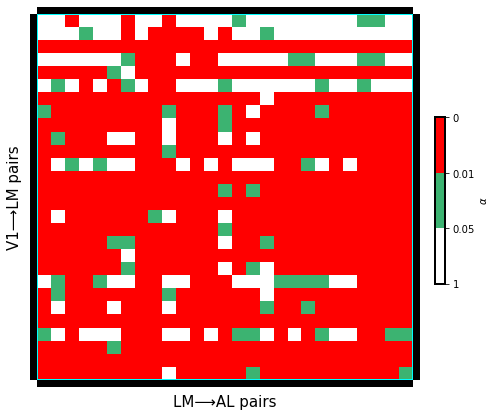

In [497]:
model.filter_membership_statistics(sub_filter_membership_CD)
model.filter_membership_statistics(sub_filter_membership_DE)
contingency_mat, chi2t_df, pval_df = model.calculate_filter_memberships_corr(sub_filter_membership_CD, sub_filter_membership_DE)
model.plot_filter_memberships_corr_beautiful(
    contingency_mat, chi2t_df, pval_df, level_order='10', multitest_method='fdr_by', file_path=None)

In [ ]:
# model.update_filter_membership(spike_times, trial_window, group_model_pars, sub_filter_membership_CD, [trial_id], parallel=True)

In [491]:
jobs_CD, jobs_DE = [], []
for trial_id in selected_trial_ids:
    job1 = delayed(model.update_filter_membership)(spike_times, trial_window, group_model_pars, 
                                                   sub_filter_membership_CD, [trial_id], parallel=True)
    job2 = delayed(model.update_filter_membership)(spike_times, trial_window, group_model_pars, 
                                                   sub_filter_membership_DE, [trial_id], parallel=True)
    jobs_CD.append(job1)
    jobs_DE.append(job2)
with Parallel(n_jobs=8, verbose=3) as parallel_pool:
    jobs_CD_out = parallel_pool(jobs_CD)
    jobs_DE_out = parallel_pool(jobs_DE)
z_CD = pd.concat(jobs_CD_out, axis=1)
z_DE = pd.concat(jobs_DE_out, axis=1)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   41.1s
[Parallel(n_jobs=8)]: Done 285 out of 285 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   36.6s
[Parallel(n_jobs=8)]: Done 285 out of 285 | elapsed:  1.5min finished


filter_membership.shape (28, 285)
membership cnt [(0.0, 1409.0), (1.0, 1659.0), (2.0, 2832.0), (3.0, 1104.0), (4.0, 976.0)]
filter_membership.shape (27, 285)
membership cnt [(0.0, 825.0), (1.0, 1718.0), (2.0, 2450.0), (3.0, 1394.0), (4.0, 1308.0)]
100%|██████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 148.53it/s]
Total sample size 756
p-val		cnt	portion
p-val<1e-06:	3	3.97e-03
p-val<1e-07:	1	1.32e-03
p-val<1e-08:	0	0.00e+00
p-val<1e-10:	0	0.00e+00
FDR BY
alpha<0.05:	5
alpha<0.01:	5
FWER Bonferroni
alpha<0.05:	6
alpha<0.01:	5
Row-col level-0 match!


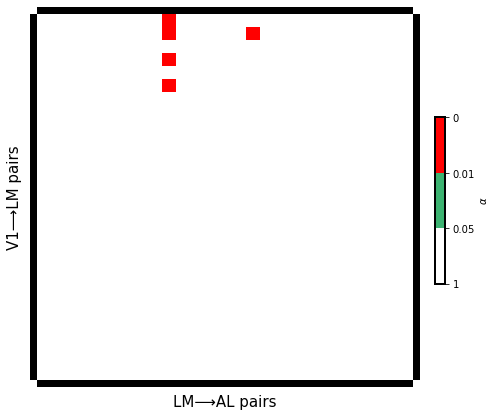

In [494]:
model.filter_membership_statistics(z_CD)
model.filter_membership_statistics(z_DE)
contingency_mat, chi2t_df, pval_df = model.calculate_filter_memberships_corr(z_CD, z_DE)
model.plot_filter_memberships_corr_beautiful(
    contingency_mat, chi2t_df, pval_df, level_order='10', multitest_method='fdr_by', file_path=None)

# Multivariate regression.

In [ ]:
neuron_drivers = [951108867, 951109594 ]  # 951109006 951109338  951108685 951109594 

nuisance_model_par = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
             'append_nuisance': ['triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 50, 'epsilon': 1e-5}

for trial_id in selected_trial_ids:
    model.update_filter_membership_multivariate(spike_times, trial_window, group_model_pars, 
        neuron_drivers, nuisance_model_par, sub_filter_membership_CD, [trial_id], parallel=False)

In [488]:
neuron_drivers = [951108867, 951109594 ]

nuisance_model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
             'append_nuisance': ['triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 50, 'epsilon': 1e-5}

jobs_CD, jobs_DE = [], []
for trial_id in selected_trial_ids:
    job1 = delayed(model.update_filter_membership_multivariate)(spike_times, trial_window, group_model_pars, 
        neuron_drivers, nuisance_model_par, sub_filter_membership_CD, [trial_id], parallel=True)
    job2 = delayed(model.update_filter_membership_multivariate)(spike_times, trial_window, group_model_pars,
        neuron_drivers, nuisance_model_par, sub_filter_membership_DE, [trial_id], parallel=True)
    jobs_CD.append(job1)
    jobs_DE.append(job2)
with Parallel(n_jobs=8, verbose=3) as parallel_pool:
    jobs_CD_out = parallel_pool(jobs_CD)
    jobs_DE_out = parallel_pool(jobs_DE)
z_CD = pd.concat(jobs_CD_out, axis=1)
z_DE = pd.concat(jobs_DE_out, axis=1)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   44.0s
[Parallel(n_jobs=8)]: Done 285 out of 285 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   42.7s
[Parallel(n_jobs=8)]: Done 285 out of 285 | elapsed:  1.8min finished


filter_membership.shape (28, 285)
membership cnt [(0.0, 1212.0), (1.0, 1494.0), (2.0, 3169.0), (3.0, 1101.0), (4.0, 1004.0)]
filter_membership.shape (27, 285)
membership cnt [(0.0, 833.0), (1.0, 1733.0), (2.0, 2570.0), (3.0, 1320.0), (4.0, 1239.0)]
filter_membership.shape (28, 285)
membership cnt [(0.0, 1484.0), (1.0, 1715.0), (2.0, 2726.0), (3.0, 1087.0), (4.0, 968.0)]
filter_membership.shape (27, 285)
membership cnt [(0.0, 921.0), (1.0, 1965.0), (2.0, 2234.0), (3.0, 1368.0), (4.0, 1207.0)]
100%|██████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 149.31it/s]
Total sample size 756
p-val		cnt	portion
p-val<1e-06:	1	1.32e-03
p-val<1e-07:	1	1.32e-03
p-val<1e-08:	1	1.32e-03
p-val<1e-10:	0	0.00e+00
FDR BY
alpha<0.05:	7
alpha<0.01:	5
FWER Bonferroni
alpha<0.05:	7
alpha<0.01:	5
Row-col level-0 match!


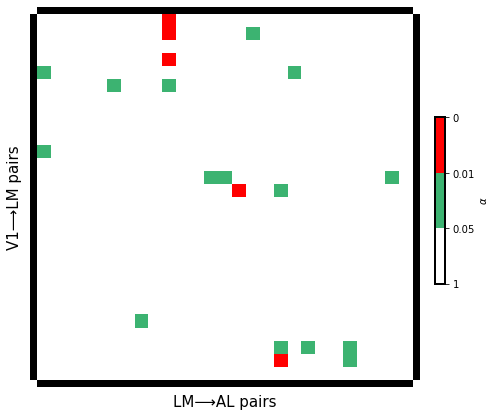

In [489]:
model.filter_membership_statistics(z_CD)
model.filter_membership_statistics(z_DE)
# model.filter_membership_statistics(sub_filter_membership_CD)
# model.filter_membership_statistics(sub_filter_membership_DE)

contingency_mat, chi2t_df, pval_df = model.calculate_filter_memberships_corr(z_CD, z_DE)
model.plot_filter_memberships_corr_beautiful(
    contingency_mat, chi2t_df, pval_df, level_order='10', multitest_method='fdr_by', file_path=None)

### Fit the filters.

filter integral [0.12650535]


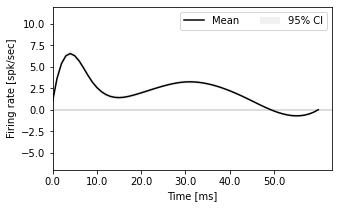

filter integral [0.12208567]


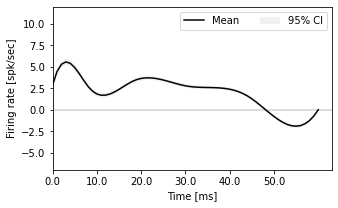

filter integral [0.07445294]


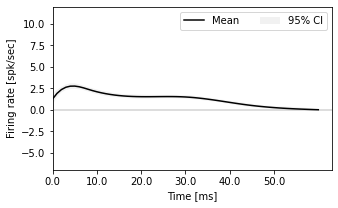

In [335]:
model_par = {'filter_type': 'bspline', 'num_knots': 6, 'knot_space_par': 0.05, 'num_tail_drop': 1, 'filter_length': 0.06,
             'append_nuisance': ['const', 'triangle_kernel'],  'const_offset': 0, 'kernel_width':0.12,
             'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_1, spike_times_2, trial_window, model_par)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, ylim=[-7, 12])

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_3, spike_times_4, trial_window, model_par)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, ylim=[-7, 12])

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_1, spike_times_4, trial_window, model_par)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, ylim=[-7, 12])